In [1]:
import os, random
import cv2
import math
import librosa
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

from collections import Counter

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import WeightedRandomSampler
from torchvision.models import efficientnet
from torchvision.transforms import transforms
# from efficientnet_pytorch import EfficientNet

import timm

import scikitplot as skplt
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit, KFold
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import LabelEncoder

from glob import glob
from IPython.display import display, Audio

import cupy as cp
from cupyx.scipy import signal as cupy_signal
import yaml

from metric import score

import wandb

import plotly.graph_objects as go
import plotly.express as px

c:\Users\hoang\anaconda3\envs\bird\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\hoang\anaconda3\envs\bird\lib\site-packages\cupyx\jit\_interface.py:173: FutureWarning: cupyx.jit.rawkernel is experimental. The interface can change in the future.
  cupy._util.experimental('cupyx.jit.rawkernel')


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [3]:
default_config = {
    "VERSION": "v0.3",
    "DATA_PATH": "inputs",
    "LOAD_SPEC_DATA": True,
    "SEED": 24,
    "SAMPLE_RATE": 32000,
    "N_FFT": 1095,
    "WIN_SIZE": 412,
    "WIN_LAP": 100,
    "MIN_FREQ": 40,
    "MAX_FREQ": 15000,
    "EPOCHS": 10,
    "BACHSIZE": 16
}

try:
    with open('config.yaml', 'r') as f:
        default_config = yaml.load(f, Loader=yaml.SafeLoader)
except:
    pass

default_config

{'VERSION': 'v2.2',
 'DESCRIPTION': 'first 5s',
 'DATA_PATH': 'inputs',
 'LOAD_SPEC_DATA': ['data/spec_first_5sec_256_256_24.npy'],
 'SEED': 24,
 'SECOND_LABEL': 1,
 'SAMPLE_RATE': 32000,
 'N_FFT': 1024,
 'WIN_SIZE': 412,
 'WIN_LAP': 100,
 'MIN_FREQ': 40,
 'MAX_FREQ': 15000,
 'N_MEL': 128,
 'HOP_LENGTH': 320,
 'XYMasking': True,
 'EPOCHS': 10,
 'FOLD': 5,
 'BACTHSIZE': 16,
 'LABEL_SMOOTHING': 0.0,
 'LOSS': 'CrossEntropyLoss'}

In [4]:
def oog2spec_via_cupy(audio_data):
    
    audio_data = cp.array(audio_data)
    
    # handles NaNs
    mean_signal = cp.nanmean(audio_data)
    audio_data = cp.nan_to_num(audio_data, nan=mean_signal) if cp.isnan(audio_data).mean() < 1 else cp.zeros_like(audio_data)
    
    # to spec.
    frequencies, times, spec_data = cupy_signal.spectrogram(
        audio_data, 
        fs=default_config["SAMPLE_RATE"], 
        nfft=default_config["N_FFT"], 
        nperseg=default_config["WIN_SIZE"], 
        noverlap=default_config["WIN_LAP"], 
        window='hann'
    )
    
    # Filter frequency range
    valid_freq = (frequencies >= default_config["MIN_FREQ"]) & (frequencies <= default_config["MAX_FREQ"])
    spec_data = spec_data[valid_freq, :]
    
    # Log
    spec_data = cp.log10(spec_data + 1e-20)
    
    # min/max normalize
    spec_data = spec_data - spec_data.min()
    spec_data = spec_data / spec_data.max()
    
    return spec_data.get()

In [5]:
meta_data = pd.read_csv(f"inputs/train_metadata.csv")
meta_data.drop_duplicates(inplace=True)

meta_data.reset_index(drop=True, inplace=True)
meta_data = meta_data[["filename","primary_label"]]
meta_data

,filename,primary_label
0,asbfly/XC134896.ogg,asbfly
1,asbfly/XC164848.ogg,asbfly
2,asbfly/XC175797.ogg,asbfly
3,asbfly/XC207738.ogg,asbfly
4,asbfly/XC209218.ogg,asbfly
...,...,...
24454,zitcis1/XC845747.ogg,zitcis1
24455,zitcis1/XC845817.ogg,zitcis1
24456,zitcis1/XC856176.ogg,zitcis1
24457,zitcis1/XC856723.ogg,zitcis1


In [8]:
# f = open("data/duplicates.txt", 'r').readlines()
# dup = [row.split(',')[0] for row in f]
# print(f"Get {len(dup)} duplicates file")
# for d in dup:
#     meta_data = meta_data[meta_data.filename!=d]
# meta_data.reset_index(drop=True)
# meta_data.drop_duplicates(subset=['filename'], inplace=True)
# meta_data.reset_index(drop=True, inplace=True)
# meta_data

In [6]:
google_start_birdcall = np.load("data/spec_google_stride1s_bird_start.npy", allow_pickle=True).item()
google_start_birdcall

{'asbfly/XC134896.ogg': 11,
 'asbfly/XC164848.ogg': 10,
 'asbfly/XC175797.ogg': 1,
 'asbfly/XC207738.ogg': 0,
 'asbfly/XC209218.ogg': 13,
 'asbfly/XC209219.ogg': 2,
 'asbfly/XC267679.ogg': 6,
 'asbfly/XC267680.ogg': 12,
 'asbfly/XC267681.ogg': 33,
 'asbfly/XC267682.ogg': 19,
 'asbfly/XC267683.ogg': 1,
 'asbfly/XC291450.ogg': 17,
 'asbfly/XC305518.ogg': 95,
 'asbfly/XC309402.ogg': 7,
 'asbfly/XC312456.ogg': 0,
 'asbfly/XC313835.ogg': 4,
 'asbfly/XC329259.ogg': 58,
 'asbfly/XC341611.ogg': 20,
 'asbfly/XC341612.ogg': 12,
 'asbfly/XC342037.ogg': 72,
 'asbfly/XC342638.ogg': 34,
 'asbfly/XC347563.ogg': 20,
 'asbfly/XC347938.ogg': 0,
 'asbfly/XC374520.ogg': 9,
 'asbfly/XC376509.ogg': 30,
 'asbfly/XC396237.ogg': 14,
 'asbfly/XC396238.ogg': 44,
 'asbfly/XC399102.ogg': 16,
 'asbfly/XC405069.ogg': 12,
 'asbfly/XC412227.ogg': 0,
 'asbfly/XC412228.ogg': 6,
 'asbfly/XC441145.ogg': 26,
 'asbfly/XC453302.ogg': 35,
 'asbfly/XC464609.ogg': 12,
 'asbfly/XC484489.ogg': 73,
 'asbfly/XC49755.ogg': 43,
 'asb

In [7]:
meta_data

,filename,primary_label
0,asbfly/XC134896.ogg,asbfly
1,asbfly/XC164848.ogg,asbfly
2,asbfly/XC175797.ogg,asbfly
3,asbfly/XC207738.ogg,asbfly
4,asbfly/XC209218.ogg,asbfly
...,...,...
24454,zitcis1/XC845747.ogg,zitcis1
24455,zitcis1/XC845817.ogg,zitcis1
24456,zitcis1/XC856176.ogg,zitcis1
24457,zitcis1/XC856723.ogg,zitcis1


In [8]:
all_bird_data = dict()

for i, row_metadata in tqdm(meta_data.iterrows()):
                
        audio_data, _ = librosa.load(f"inputs/train_audio/{row_metadata.filename}", sr=default_config["SAMPLE_RATE"])

        n_copy = math.ceil(5 * default_config["SAMPLE_RATE"] / len(audio_data))
        if n_copy > 1: audio_data = np.concatenate([audio_data]*n_copy)

        # for start_idx in range(0,len(audio_data)-(len(audio_data)%(5*default_config["SAMPLE_RATE"])),5*default_config["SAMPLE_RATE"]):
        # start_idx = int(start_idx)
        # start_idx = int(len(audio_data) / 2 - 2.5 * default_config["SAMPLE_RATE"])
        start_idx = int(google_start_birdcall[row_metadata.filename] * default_config["SAMPLE_RATE"])
        end_idx = int(start_idx + 5.0 * default_config["SAMPLE_RATE"])
        input_audio = audio_data[start_idx:end_idx]

        # ogg to spec.
        input_spec = oog2spec_via_cupy(input_audio)

        input_spec = cv2.resize(input_spec, (256, 256), interpolation=cv2.INTER_AREA)

        all_bird_data[f"{row_metadata.filename}_{start_idx}"] = input_spec.astype(np.float32)
# save to file
np.save(os.path.join("data", f'spec_google1s_5sec_256_256_24.npy'), all_bird_data)

0it [00:00, ?it/s]

24459it [14:09, 28.78it/s]


### Extract No Call class

In [ ]:
from pydub import AudioSegment
import os

In [ ]:
os.environ["PATH"] += os.pathsep + 'C:/Users/hoang/Downloads/ffmpeg-master-latest-win64-gpl-shared/bin/ffmpeg.exe'
os.environ["PATH"] += os.pathsep + 'C:/Users/hoang/Downloads/ffmpeg-master-latest-win64-gpl-shared/bin/ffplay.exe'
os.environ["PATH"] += os.pathsep + 'C:/Users/hoang/Downloads/ffmpeg-master-latest-win64-gpl-shared/bin/ffprobe.exe'

In [ ]:
AudioSegment.converter = 'C:/Users/hoang/Downloads/ffmpeg-master-latest-win64-gpl-shared/bin/ffmpeg.exe'
AudioSegment.ffmpeg = 'C:/Users/hoang/Downloads/ffmpeg-master-latest-win64-gpl-shared/bin/ffmpeg.exe'
AudioSegment.ffprobe =  'C:/Users/hoang/Downloads/ffmpeg-master-latest-win64-gpl-shared/bin/ffprobe.exe'

In [ ]:
p = "inputs/previous_dataset/ColumbiaAndCostaRica" # SouthwesternAmazonBasin" # WesternUS"
anno = pd.read_csv(f"{p}/annotations.csv")
anno = anno[anno["Species eBird Code"]=="????"].reset_index(drop=True)
anno

,Filename,Start Time (s),End Time (s),Low Freq (Hz),High Freq (Hz),Species eBird Code
0,NES_001_S01_20190914_043000.flac,1980.9,1981.3,7183,10000,????
1,NES_001_S01_20190914_043000.flac,1991.8,1992.3,7042,10845,????
2,NES_001_S01_20190914_043000.flac,1993.7,1994.1,7323,9718,????
3,NES_001_S01_20190914_043000.flac,1996.3,1996.8,7042,10281,????
4,NES_001_S01_20190914_043000.flac,2539.1,2539.4,7464,9859,????
...,...,...,...,...,...,...
381,NES_032_S02_20191009_063001.flac,3587.6,3588.2,4354,9516,????
382,NES_032_S02_20191009_063001.flac,3591.7,3592.2,5000,10161,????
383,NES_033_S02_20191009_160000.flac,1368.5,1370.9,3559,6271,????
384,NES_034_S02_20191009_170000.flac,2507.6,2508.4,0,2372,????


In [ ]:
for idx in tqdm(range(len(anno))):
    if (anno["End Time (s)"][idx]- anno["Start Time (s)"][idx]) > 5:

        newAudio = AudioSegment.from_file(f"{p}/soundscape_data/{anno['Filename'][idx]}", 'flac')
        newAudio = newAudio[anno['Start Time (s)'][idx]*1000:anno['End Time (s)'][idx]*1000]
        newAudio.export(f'inputs/train_audio/nocall/ColumbiaAndCostaRica_{idx}.ogg', format="ogg")


100%|██████████| 386/386 [02:57<00:00,  2.17it/s]


In [ ]:
noCallFiles = glob("inputs/train_audio/nocall/*.ogg")
meta_data = pd.DataFrame(noCallFiles, columns=["filename"])
meta_data

,filename
0,inputs/train_audio/nocall\ColumbiaAndCostaRica...
1,inputs/train_audio/nocall\ColumbiaAndCostaRica...
2,inputs/train_audio/nocall\ColumbiaAndCostaRica...
3,inputs/train_audio/nocall\ColumbiaAndCostaRica...
4,inputs/train_audio/nocall\ColumbiaAndCostaRica...
...,...
296,inputs/train_audio/nocall\SouthwesternAmazonBa...
297,inputs/train_audio/nocall\SouthwesternAmazonBa...
298,inputs/train_audio/nocall\SouthwesternAmazonBa...
299,inputs/train_audio/nocall\SouthwesternAmazonBa...


In [ ]:
def clean_filename(row):
    return row.split("/")[-1].replace("\\","/")

meta_data["filename"] = meta_data["filename"].apply(clean_filename)
meta_data

,filename
0,nocall/ColumbiaAndCostaRica_102.ogg
1,nocall/ColumbiaAndCostaRica_103.ogg
2,nocall/ColumbiaAndCostaRica_106.ogg
3,nocall/ColumbiaAndCostaRica_11.ogg
4,nocall/ColumbiaAndCostaRica_111.ogg
...,...
296,nocall/SouthwesternAmazonBasin_987.ogg
297,nocall/SouthwesternAmazonBasin_989.ogg
298,nocall/SouthwesternAmazonBasin_993.ogg
299,nocall/SouthwesternAmazonBasin_994.ogg


In [ ]:
all_bird_data = dict()

for i, row_metadata in tqdm(meta_data.iterrows()):
                
        audio_data, _ = librosa.load(f"inputs/train_audio/{row_metadata.filename}", sr=default_config["SAMPLE_RATE"])

        n_copy = math.ceil(5 * default_config["SAMPLE_RATE"] / len(audio_data))
        if n_copy > 1: audio_data = np.concatenate([audio_data]*n_copy)

        # for start_idx in range(0,len(audio_data)-(len(audio_data)%(5*default_config["SAMPLE_RATE"])),5*default_config["SAMPLE_RATE"]):
        # start_idx = int(start_idx)
        # start_idx = int(len(audio_data) / 2 - 2.5 * default_config["SAMPLE_RATE"])
        start_idx = 0
        end_idx = int(start_idx + 5.0 * default_config["SAMPLE_RATE"])
        input_audio = audio_data[start_idx:end_idx]

        # ogg to spec.
        input_spec = oog2spec_via_cupy(input_audio)

        input_spec = cv2.resize(input_spec, (256, 256), interpolation=cv2.INTER_AREA)

        all_bird_data[f"{row_metadata.filename}_{start_idx}"] = input_spec.astype(np.float32)
# save to file
np.save(os.path.join("data", f'spec_first_5sec_256_256_nocall.npy'), all_bird_data)

301it [00:08, 35.51it/s]


### bird-vocalization-classifier || Google

In [ ]:
label = pd.read_csv("inputs/bird-vocalization-classifier/assets/label.csv")

In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_io as tfio

In [7]:
def frame_audio(
      audio_array: np.ndarray,
      window_size_s: float = 5.0,
      hop_size_s: float = 5.0,
      sample_rate = 32000,
  ) -> np.ndarray:
    """Helper function for framing audio for inference."""
    if window_size_s is None or window_size_s < 0:
      return audio_array[np.newaxis, :]
    frame_length = int(window_size_s * sample_rate)
    hop_length = int(hop_size_s * sample_rate)
    framed_audio = tf.signal.frame(audio_array, frame_length, hop_length, pad_end=True)
    return framed_audio

In [71]:
filepath = random.choice(glob("inputs/train_audio/*/*.ogg"))
# filepath = "inputs/train_audio/commoo3/XC645668.ogg"
# filepath = "inputs/train_audio/rerswa1/XC697561.ogg"
audio, sample_rate = librosa.load(filepath, sr=32000)

n_copy = math.ceil(5 *32000 / len(audio))
if n_copy > 1: audio = np.concatenate([audio]*n_copy)

print(filepath)
display(Audio(filepath))

s5_audio = []
list_start_second = []
duration = len(audio)/32000
last_5s = duration-(duration%5)-5
start_second = 0

while start_second<=last_5s:
        start_idx = int(start_second*32000)
        end_idx = int((start_second+5.0) * 32000)
        
        input_audio = audio[start_idx:end_idx]

        list_start_second.append((start_second,end_idx/32000))
        s5_audio.append(frame_audio(input_audio))

        start_second +=1

input_spec = oog2spec_via_cupy(audio)


inputs/train_audio\lirplo\XC562310.ogg


Bird call (9, 14.0)s


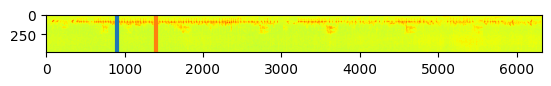

In [72]:
# Load the model.
model = hub.load('https://www.kaggle.com/models/google/bird-vocalization-classifier/TensorFlow2/bird-vocalization-classifier/8')

specices_logits = []
score = []
for au in s5_audio:
    probabilities = tf.nn.sigmoid(model.infer_tf(au)["label"])
    score.append(probabilities.numpy()[0].sum())

print(f"Bird call {list_start_second[np.argmax(score)]}s")

x = [x for x in range(np.squeeze(input_spec).shape[0])]
y = np.empty(len(x))
y.fill(list_start_second[np.argmax(score)][0]*100)

plt.plot(y,x,linewidth=3) 

y.fill(list_start_second[np.argmax(score)][1]*100)
plt.plot(y,x,linewidth=3) 

plt.imshow(np.squeeze(input_spec), cmap='jet')
plt.show()

In [ ]:
all_bird_data = dict()
model = hub.load('https://www.kaggle.com/models/google/bird-vocalization-classifier/TensorFlow2/bird-vocalization-classifier/8')

for i, row_metadata in tqdm(meta_data.iterrows()):
                
        audio_data, _ = librosa.load(f"inputs/train_audio/{row_metadata.filename}", sr=default_config["SAMPLE_RATE"])

        n_copy = math.ceil(5 * default_config["SAMPLE_RATE"] / len(audio_data))
        if n_copy > 1: audio_data = np.concatenate([audio_data]*n_copy)

        start_second = []
        s5_audio = []

        for start_idx in range(0,len(audio_data)-(len(audio_data)%(5*32000)),5*32000):
            start_idx = int(start_idx)
            end_idx = int(start_idx + 5.0 * 32000)
            input_audio = audio_data[start_idx:end_idx]
            start_second.append(start_idx/32000)
            s5_audio.append(frame_audio(input_audio))

        specices_logits = []
        score = []
        for au in s5_audio:
            probabilities = tf.nn.sigmoid(model.infer_tf(au)["label"])
            score.append(probabilities.numpy()[0].sum())

        start_idx = int(start_second[np.argmax(score)])
        end_idx = int(start_idx + 5.0 * default_config["SAMPLE_RATE"])
        input_audio = audio_data[start_idx:end_idx]

        # ogg to spec.
        input_spec = oog2spec_via_cupy(input_audio)

        input_spec = cv2.resize(input_spec, (256, 256), interpolation=cv2.INTER_AREA)

        all_bird_data[f"{row_metadata.filename}_{start_idx}"] = input_spec.astype(np.float32)
# save to file
np.save(os.path.join("data", f'spec_google_5sec_256_256_24.npy'), all_bird_data)

In [14]:
class BirdCLEF_Model_EfficientnetB0(nn.Module):
    def __init__(self, num_class):
        super(BirdCLEF_Model_EfficientnetB0, self).__init__()
        self.backbone = timm.create_model('tf_efficientnet_b0.in1k', pretrained=True, in_chans=1,  num_classes=num_class)
    
    def forward(self, x):
        x = self.backbone(x)
        return x

In [16]:
input_tensor = torch.randn(16, 1, 256, 256)

from openvino.runtime import Core
import openvino as ov


for fold in range(1):
    bird_model = BirdCLEF_Model_EfficientnetB0(num_class=182)
    weights = torch.load(f"model/v2.0/BaseModel_EfficientB0_Fold{fold}.pt", map_location=torch.device('cpu'))
    bird_model.load_state_dict(weights)
    bird_model.eval()

    ov_model = ov.convert_model(bird_model, example_input=input_tensor)
    ov.save_model(ov_model, f"model/v2.0/BaseModel_EfficientB0_Fold{fold}.xml")